## <strong> Architecture of GoogLeNet </strong>

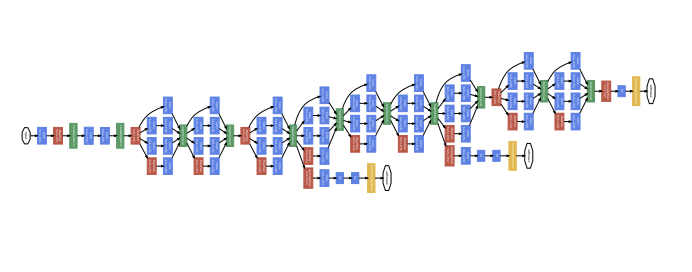

## <strong> Import Header </strong>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

## <strong> Set Device </strong>

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)

## <strong> Set Hyper Parameters </strong>

In [3]:
momentum = 0.9
learning_rate = 1e-4
total_epoch = 50
batch_size = 32
aux = True

## <strong> Define Dataset / DataLoader </strong>

In [5]:
train_data = dsets.CIFAR10(root='./Cifar10', train=True, transform=transforms.ToTensor(), download=True)
val_data = dsets.CIFAR10(root='./Cifar10', train=False, transform=transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(f'Image Size: {train_data[0][0].shape}')

Image Size: torch.Size([3, 32, 32])


In [7]:
# get RGB mean, std in train_data
train_meanRGB = pd.DataFrame([np.mean(image.numpy(), axis=(1, 2)) for image, _ in train_data], columns=['R', 'G', 'B'])
train_stdRGB = pd.DataFrame([np.std(image.numpy(), axis=(1, 2)) for image, _ in train_data], columns=['R', 'G', 'B'])

In [8]:
train_meanRGB.head()

,R,G,B
0,0.553745,0.412155,0.251126
1,0.510585,0.511236,0.511677
2,0.523468,0.530009,0.519941
3,0.392076,0.326585,0.225153
4,0.360869,0.401570,0.454913


In [9]:
train_meanR = np.mean(train_meanRGB['R'])
train_meanG = np.mean(train_meanRGB['G'])
train_meanB = np.mean(train_meanRGB['B'])
train_stdR = np.mean(train_stdRGB['R'])
train_stdG = np.mean(train_stdRGB['G'])
train_stdB = np.mean(train_stdRGB['B'])

In [10]:
# define transform
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((224, 224)),
                                transforms.Normalize([train_meanR, train_meanG, train_meanB],[train_stdR, train_stdG, train_stdB])
])

In [11]:
# redefine train_data, test_data's transforms
train_data.transform = transform
val_data.transform = transform

In [12]:
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size = batch_size, shuffle=True, drop_last=True)

## <strong> Define Model </strong>

In [13]:
class conv_block(nn.Module):
  def __init__(self, in_channels, out_channels, **kwargs):
    super().__init__()

    # Each Convolution layer's structure (Conv, BN, ReLU)
    self.conv_layer = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, **kwargs),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(),
      )
    
  def forward(self, x):
    return self.conv_layer(x)

In [14]:
class Inception_block(nn.Module):
  def __init__(self, in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool):
    super().__init__()

    # 1×1 Convolutions
    self.branch1 = conv_block(in_channels, out_1x1, kernel_size=1)

    # 1×1 Convolutions and 3×3 Convolutions
    self.branch2 = nn.Sequential(
        conv_block(in_channels, red_3x3, kernel_size=1),
        conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )
    
    # 1×1 Convolutions and 5×5 Convolutions
    self.branch3 = nn.Sequential(
        conv_block(in_channels, red_5x5, kernel_size=1),
        conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )

    # 3×3 Max Pooling and 1×1 Convolutions
    self.branch4 = nn.Sequential(
        nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
        conv_block(in_channels, out_1x1pool, kernel_size=1)
        )

  def forward(self, x): 
    # Filter concatenation
    x = torch.cat([self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)], 1)
    return x

In [15]:
class InceptionAux(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    # in_channels = 512 or 528
    # previous_layer_output = 14×14×in_channels
    # if conduct avgpool and conv the Tensor Shape is 4×4×128 = 2048
    self.conv = nn.Sequential(
      nn.AvgPool2d(kernel_size=5, stride=3),
      conv_block(in_channels, 128, kernel_size=1),
      )

    self.fc = nn.Sequential(
      nn.Linear(2048, 1024),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(1024, num_classes),
      )
    
  def forward(self,x):
    x = self.conv(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

In [16]:
class GoogLeNet(nn.Module):
  def __init__(self, aux=True, num_classes=10, init_weights=True):
    super().__init__()
    self.aux = aux

    # conv_block takes in_channels, out_channels, kernel_size, stride, padding
    # Inception block takes out1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool

    self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3) # output: 112×112×64
    self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)   # output: 56×56×64
    self.conv2 = nn.Sequential(
        conv_block(64, 64, kernel_size=1),
        conv_block(64, 192, kernel_size=3, padding=1)
    )                                                                    # output: 56×56×196
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)     # output: 28×28×196

    self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)     # output: 28×28×256 (64+128+32+32=256)
    self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)   # output: 28×28×480 (128+192+96+64)
    self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)     # output: 14×14×480
    
    self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)    # output: 14×14×512 (192+208+48+64)
    self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)   # output: 14×14×512 (160+224+64+64) / including auxiliary classifier
    self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)   # output: 14×14×512 (128+256+64+64)
    self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)   # output: 14×14×528 (112+288+64+64) / including auxiliary classifier
    self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128) # output: 14×14×832 (256+320+128+128)
    self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)     # output: 7×7×832

    self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128) # output: 7×7×832
    self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128) # output: 7×7×1024

    self.avgpool = nn.AvgPool2d(7, 1)                                    # output: 1×1×1024
    self.dropout = nn.Dropout(p=0.4)                                     # output: 1×1×1024
    self.fc1 = nn.Linear(1024, num_classes)                              # output: 1×1×num_classes
    
    # auxiliary classifier
    if self.aux:
      self.aux1 = InceptionAux(512, num_classes)
      self.aux2 = InceptionAux(528, num_classes)
    else:
      self.aux1 = self.aux2 = None

    # weight initialization
    if init_weights:
      self.initialize_weights()

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.inception3a(x)
    x = self.inception3b(x)
    x = self.maxpool3(x)
    x = self.inception4a(x)

    if self.aux and self.training:
      aux1 = self.aux1(x)

    x = self.inception4b(x)
    x = self.inception4c(x)
    x = self.inception4d(x)

    if self.aux and self.training:
      aux2 = self.aux2(x)

    x = self.inception4e(x)
    x = self.maxpool4(x)
    x = self.inception5a(x)
    x = self.inception5b(x)
    x = self.avgpool(x)

    x = x.view(x.shape[0], -1)

    x = self.dropout(x)
    x = self.fc1(x)

    if self.aux and self.training:
      return x, aux1, aux2
    else:
      return x
  
  def initialize_weights(self):
    for i in self.modules():
      if isinstance(i, nn.Conv2d):
        nn.init.kaiming_normal_(i.weight, mode='fan_in', nonlinearity='relu')
        if i.bias is not None:
          nn.init.constant_(i.bias, 0)
        elif isinstance(i, nn.BatchNorm2d):
          nn.init.constant_(i.weight, 1)
          nn.init.constant_(i.bias, 0)
        elif isinstance(i, nn.Linear):
          nn.init.normal_(i.weight, 0, 0.01)
          nn.init.constant_(i.bias, 0)

## <strong> Training </strong>

In [17]:
model = GoogLeNet(aux=aux, num_classes=10, init_weights=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
criterion = nn.CrossEntropyLoss()

In [18]:
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

total_train_image = len(train_data)
total_train_batch = len(train_loader)
total_val_image = len(val_data)
total_val_batch = len(val_loader)
for epoch in range(total_epoch):
  model.train()
  train_accuracy = 0
  train_loss = 0
  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    if aux == True:
      hypothesis, aux1, aux2 = model(images)
      output_loss = criterion(hypothesis, labels)
      aux1_loss = criterion(aux1, labels)
      aux2_loss = criterion(aux2, labels)
      loss = output_loss + 0.3*(aux1_loss+aux2_loss)
    
    else:
      loss = criterion(hypothesis, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    prediction = torch.argmax(hypothesis, 1)
    correct = (prediction == labels)
    train_accuracy += correct.sum().item() / total_train_image
    train_loss += loss.item() / total_train_batch

  model.eval()
  val_accuracy = 0
  val_loss = 0
  for images, labels in val_loader:
    images = images.to(device)
    labels = labels.to(device)

    prediction = model(images)
    loss = criterion(prediction, labels)
    correct = (torch.argmax(prediction, 1) == labels)
    val_accuracy += correct.sum().item() / total_val_image
    val_loss += loss.item() / total_val_batch

  print(f'epoch: {epoch}/{total_epoch} train_loss: {train_loss:.5} train_accuracy: {train_accuracy:.5} val_loss: {val_loss:.5} val_accuracy: {val_accuracy:.5}')

  train_acc_list.append(train_accuracy)
  train_loss_list.append(train_loss)
  val_acc_list.append(val_accuracy)
  val_loss_list.append(val_loss)

epoch: 0/50 train_loss: 3.4125 train_accuracy: 0.21926 val_loss: 1.8389 val_accuracy: 0.3309
epoch: 1/50 train_loss: 2.9162 train_accuracy: 0.33002 val_loss: 1.6299 val_accuracy: 0.4055
epoch: 2/50 train_loss: 2.6603 train_accuracy: 0.3884 val_loss: 1.516 val_accuracy: 0.4402
epoch: 3/50 train_loss: 2.4857 train_accuracy: 0.43176 val_loss: 1.4336 val_accuracy: 0.4804
epoch: 4/50 train_loss: 2.3453 train_accuracy: 0.46862 val_loss: 1.3384 val_accuracy: 0.5048
epoch: 5/50 train_loss: 2.2261 train_accuracy: 0.50252 val_loss: 1.2719 val_accuracy: 0.5417
epoch: 6/50 train_loss: 2.119 train_accuracy: 0.5292 val_loss: 1.2023 val_accuracy: 0.5662
epoch: 7/50 train_loss: 2.0142 train_accuracy: 0.55684 val_loss: 1.1607 val_accuracy: 0.5834
epoch: 8/50 train_loss: 1.9275 train_accuracy: 0.5771 val_loss: 1.0988 val_accuracy: 0.6066
epoch: 9/50 train_loss: 1.8418 train_accuracy: 0.59662 val_loss: 1.053 val_accuracy: 0.6215
epoch: 10/50 train_loss: 1.7659 train_accuracy: 0.61888 val_loss: 1.0479 val

## <strong> Result </strong>

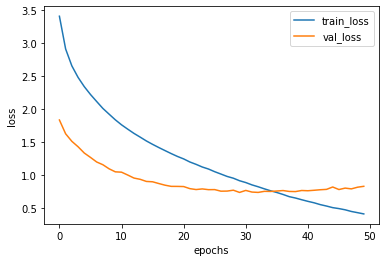

In [20]:
plt.plot(train_loss_list, label='train_loss')
plt.plot(val_loss_list, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

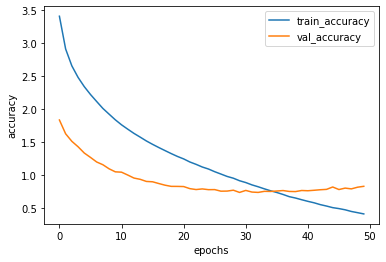

In [21]:
plt.plot(train_loss_list, label='train_accuracy')
plt.plot(val_accuracy_list, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

<h3> <strong> torch.nn.Module.training </strong> </h3> 

training (bool) – Boolean represents whether this module is in training or evaluation mode.

Code Reference: https://www.youtube.com/watch?v=uQc4Fs7yx5I&t=39s